In [1]:
import kagglehub
import pandas as pd
import os

path = kagglehub.dataset_download("justinpakzad/vestiaire-fashion-dataset")
print("Path to dataset files:", path)
df = pd.read_csv(os.path.join(path, 'vestiaire.csv'), low_memory=False)

Path to dataset files: /Users/banutiryaki/.cache/kagglehub/datasets/justinpakzad/vestiaire-fashion-dataset/versions/2


In [2]:
df['item_type'] = df['product_type'].str.strip().str.split().str[-1].str.lower()

In [3]:
type_counts = df['item_type'].value_counts()
df = df[df['item_type'].isin(type_counts[type_counts > 1].index)]

In [4]:
brand_counts = df['brand_name'].value_counts()

top_n = [50, 100, 200, 500, 1000, 2000]
for n in top_n:
    covered = brand_counts.iloc[:n].sum()
    total = len(df)
    percent = round(covered / total * 100, 2)
    print(f"Top {n} brands cover {covered} products ({percent}%)")


Top 50 brands cover 413161 products (45.88%)
Top 100 brands cover 528278 products (58.66%)
Top 200 brands cover 629866 products (69.95%)
Top 500 brands cover 743651 products (82.58%)
Top 1000 brands cover 809934 products (89.94%)
Top 2000 brands cover 857565 products (95.23%)


In [5]:
top_1000_brands = df['brand_name'].value_counts().nlargest(1000).index
df['brand_trimmed'] = df['brand_name'].where(df['brand_name'].isin(top_1000_brands), 'other')

In [6]:
condition_map = {
    'Fair condition': 0,
    'Good condition': 1,
    'Very good condition': 2,
    'Never worn': 3,
    'Never worn, with tag': 4
}
df['product_condition_mapped'] = df['product_condition'].map(condition_map)


In [7]:
gender_map = {
    'Women': 0,
    'Men': 1
}
df['gender_encoded'] = df['product_gender_target'].map(gender_map)


In [8]:
df = df[df['price_usd'] != df['price_usd'].max()]

In [15]:
df['sold_binary'] = df['sold'].astype(int)
df['sold_binary'].value_counts(normalize=True) * 100

sold_binary
0    98.474637
1     1.525363
Name: proportion, dtype: float64

In [16]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Make a copy
df_clf = df.copy()

# Target
y = df_clf['sold_binary']

# Label encode brand_trimmed
brand_encoder = LabelEncoder()
df_clf['brand_encoded'] = brand_encoder.fit_transform(df_clf['brand_trimmed'])

# One-hot encode item_type and seller_country
df_clf = pd.get_dummies(df_clf, columns=['item_type', 'seller_country'], prefix=['item', 'country'])

# Final feature list
feature_cols = (
    [col for col in df_clf.columns if col.startswith('item_') or col.startswith('country_')] +
    ['brand_encoded', 'price_usd', 'product_condition_mapped', 'gender_encoded']
)

# Feature matrix
X = df_clf[feature_cols]


In [18]:
from sklearn.model_selection import train_test_split

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [19]:
from lightgbm import LGBMClassifier

# Initialize the model
lgb_clf = LGBMClassifier(
    objective='binary',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42,
    is_unbalance=True  # handles class imbalance
)

# Fit the model
lgb_clf.fit(X_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 10989, number of negative: 709416
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 815
[LightGBM] [Info] Number of data points in the train set: 720405, number of used features: 157
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015254 -> initscore=-4.167547
[LightGBM] [Info] Start training from score -4.167547


LGBMClassifier(is_unbalance=True, learning_rate=0.05, n_estimators=1000,
               objective='binary', random_state=42)

Confusion Matrix:
[[131336  46019]
 [   915   1832]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9931    0.7405    0.8484    177355
           1     0.0383    0.6669    0.0724      2747

    accuracy                         0.7394    180102
   macro avg     0.5157    0.7037    0.4604    180102
weighted avg     0.9785    0.7394    0.8366    180102


ROC AUC: 0.7714


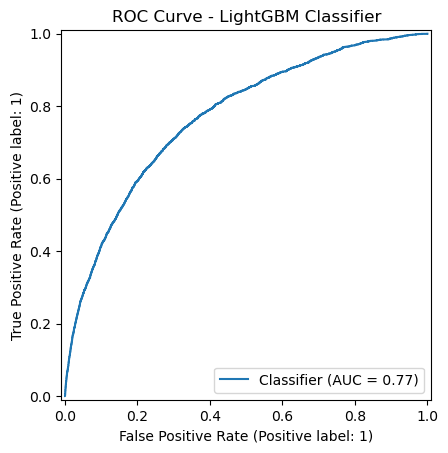

In [20]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)
import matplotlib.pyplot as plt

# Predict probabilities and classes
y_pred = lgb_clf.predict(X_test)
y_proba = lgb_clf.predict_proba(X_test)[:, 1]

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# AUC
auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC: {auc:.4f}")

# Plot ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve - LightGBM Classifier")
plt.show()


In [22]:
# Apply new threshold
threshold = 0.75
y_pred_custom = (y_proba >= threshold).astype(int)

# Re-evaluate
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_custom))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_custom, digits=4))


Confusion Matrix:
[[172851   4504]
 [  2233    514]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9872    0.9746    0.9809    177355
           1     0.1024    0.1871    0.1324      2747

    accuracy                         0.9626    180102
   macro avg     0.5448    0.5809    0.5566    180102
weighted avg     0.9738    0.9626    0.9679    180102



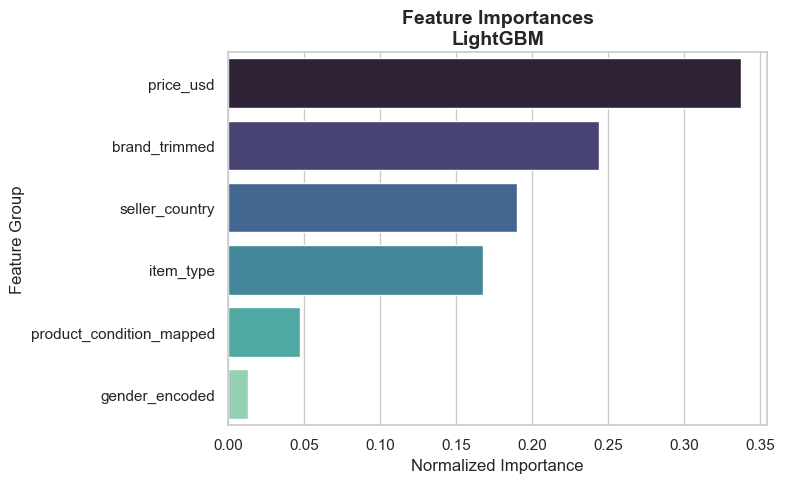

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get raw importances
importances = lgb_clf.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Normalize importances to sum to 1
feat_imp_df['normalized_importance'] = feat_imp_df['importance'] / feat_imp_df['importance'].sum()

# Group similar features under a category
def categorize_feature(name):
    if name.startswith("item_"):
        return "item_type"
    elif name.startswith("country_"):
        return "seller_country"
    elif name == "brand_encoded":
        return "brand_trimmed"
    else:
        return name  # for price_usd, product_condition_mapped, etc.

feat_imp_df['category'] = feat_imp_df['feature'].apply(categorize_feature)

# Group and sort
grouped = feat_imp_df.groupby('category')['normalized_importance'].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")

sns.barplot(x=grouped.values, y=grouped.index, palette="mako")

plt.xlabel("Normalized Importance", fontsize=12)
plt.ylabel("Feature Group", fontsize=12)
plt.title("Feature Importances\nLightGBM", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


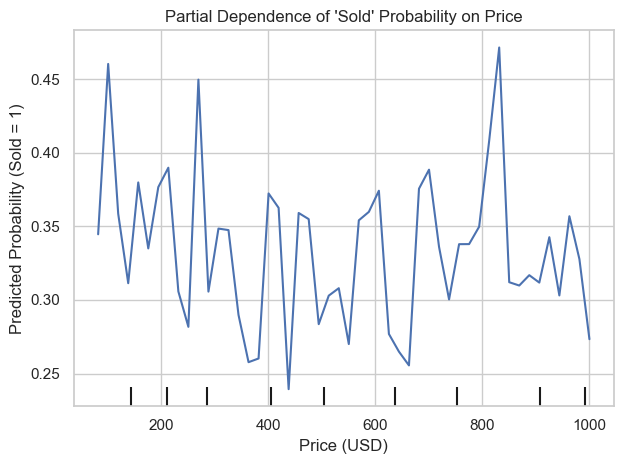

In [35]:
from sklearn.inspection import PartialDependenceDisplay

# Sample a small subset for speed
X_sample = X.sample(2000, random_state=42)

PartialDependenceDisplay.from_estimator(
    lgb_clf,
    X_sample,
    features=['brand_encoded'],
    kind='average',
    grid_resolution=50,
    target=1
)

plt.title("Partial Dependence of 'Sold' Probability on Price")
plt.xlabel("Price (USD)")
plt.ylabel("Predicted Probability (Sold = 1)")
plt.tight_layout()
plt.show()
